In [323]:
import diffeq_2 as methods
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft, signal

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import pandas as pd
# sns.set_theme()
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


Že iz gimnazije poznamo, da nam matematično nihalo poda analitično nerešljivo diferencialno enačbo
ENAČBA

In [324]:
def exact(t, x0, w0):
    return 2*np.arcsin(np.sin(x0/2) * special.ellipj(special.ellipk((np.sin(x0/2))**2) - w0*t, ((np.sin(x0/2))**2))[0])

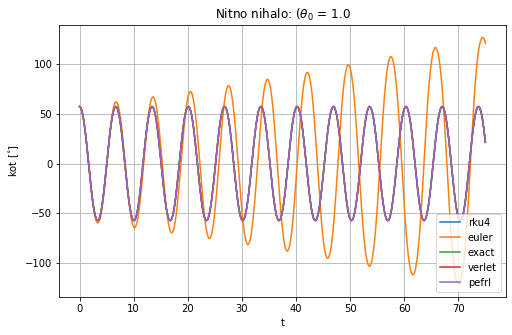

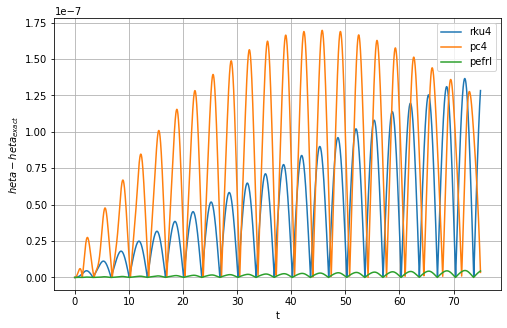

In [325]:
a = 1
w0 = np.sqrt(a)


def f_2(theta): return -a * np.sin(theta)

# define the equations
def equations(y0,y1):
    theta, x = y0
    f = np.array([x, f_2(theta)], dtype=np.float64)
    return f

t = np.arange(0, 75, 0.025)

# initial conditions
# initial_angle = 1
# theta0 = np.radians(initial_angle)
theta0 = 1.0
x0 = np.radians(0.0)

# find the solution to the nonlinear problem
theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
theta_euler = methods.euler(equations, [theta0, x0],  t)
theta_pc4= methods.pc4(equations, [theta0, x0],  t)

theta_exact = exact(t, theta0, w0)

theta_verlet = methods.verlet(f_2, theta0, x0, t)
theta_pefrl = methods.pefrl(f_2, theta0, x0, t)

# plot the results
plt.plot(t, np.rad2deg(theta_rku4[:, 0]), label='rku4')
plt.plot(t, np.rad2deg(theta_euler[:, 0]), label='euler')
plt.plot(t, np.rad2deg(theta_exact), label='exact')
plt.plot(t, np.rad2deg(theta_verlet[0, :]), label='verlet')
plt.plot(t, np.rad2deg(theta_pefrl[0, :]), label='pefrl')
# plt.plot(t, np.rad2deg(theta2))

s = r'($\theta_0$ = ' + str(theta0)
plt.title('Nitno nihalo: ' + s)
plt.xlabel('t')
plt.ylabel('kot [$^{\circ}$]')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig("grafi/nihalo.pdf", bbox_inches='tight')
plt.show()


def diff_abs_exact(method):
    return np.abs(method - theta_exact)


plt.plot(t, diff_abs_exact(theta_rku4[:, 0]), label='rku4')
plt.plot(t, diff_abs_exact(theta_pc4[:, 0]), label='pc4')
#plot verlet
plt.plot(t, diff_abs_exact(theta_pefrl[0, :]), label='pefrl')
plt.legend()
plt.xlabel('t')
plt.ylabel('$\theta - \theta_{exact}$')
plt.grid()
plt.savefig("grafi/nihalo_napake.pdf", bbox_inches='tight')

plt.show()

Najprej lahko narišemo čisto navadne grafe izračunov rešitve diferencialne enačbe. Eksaktna enačba je seveda dvojni eliptični integral, ki jo lahko zgolj poberemo iz knjižnice SciPy. Iz grafa lahko opazimo, da so vse metoda na prvi pogled zelo natančne (v mojem primeru majhnega $\delta t$), razen Eulerjeve metode, ki bi potrebovala še bistveno menjšega, da bi bila uporabna. Pri Eulerjevi metodi se očitno iz grafa energija pridobiva, kar je seveda fizikalno gledano malce smešno.

Če se sedaj osredotočimo na napako, ki jo dobimo pri metodah, je smiselno narisati časovno odvisnost napak od analitične (ki vbistvu sama po sebi ni popolnoma natančna, ker je zgolj numerično izračunan eliptični integral, vendar je zelo dobra referenca). Eulerjeve metode sploh ne bom narisal, ker ni smiselno. Vidimo, da metode lahko dosežejo zelo veliko natančnost. Problem Runga-Kutta (ki je gold standard) je, da napaka v odvisnosti od časa linearno narašča Energija pa se izgublja, kar nam zelo poslabša sliko. Boljša je simplektična metoda PEFRL, ki napako ohranja blizu ničle, Energija pa se tudi ohranja, kot bomo videli kasneje.

In [326]:
# createAnimation(np.array([theta_exact, theta_euler[:, 0]]), 'amazing')

## Časovna zahtevnost

In [327]:
def lin_fit(x, a, b):
    return x*a+b

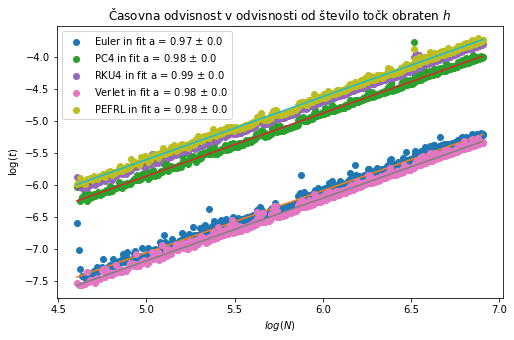

In [328]:
x_max = 15  # nima zares veze kero uzams, vazn da lah primerjas pac
# hs = np.linspace(1e-3, 1e-1, 100)

ns = np.int16(np.arange(1e2, 1e3))

end_t = x_max
dpoints = 15

euler = np.empty_like(ns, dtype=float)
pc4 = np.empty_like(ns, dtype=float)
rku4 = np.empty_like(ns, dtype=float)
verlet = np.empty_like(ns, dtype=float)
pefrl = np.empty_like(ns, dtype=float)

for i in range(len(ns)):
    t = np.linspace(0, end_t, num=ns[i])

    start = time.time()
    methods.euler(equations, [theta0, x0],  t)
    euler[i] = time.time() - start

    start = time.time()
    theta_pc4 = methods.pc4(equations, [theta0, x0],  t)
    pc4[i] = time.time()-start

    start = time.time()
    theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
    rku4[i] = time.time()-start

    start = time.time()
    theta_verlet = methods.verlet(f_2, theta0, x0, t)
    verlet[i] = time.time()-start

    start = time.time()
    theta_pefrl = methods.pefrl(f_2, theta0, x0, t)
    pefrl[i] = time.time()-start


def koef_and_draw(ns, data, name):
    x = np.log(ns)
    y = np.log(data)

    # non_inf = np.argmax(y != -np.inf)

    # x, y = x[non_inf:], y[non_inf:]

    popt, pcov = optimize.curve_fit(lin_fit, x, y)
    errs = np.sqrt(np.diag(pcov))

    a = popt[0], errs[0]

    plt.plot(
        x, y, 'o', label=f'{name} in fit a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    # , label=f'{name} fit; a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    plt.plot(x, lin_fit(x, *popt))


koef_and_draw(ns, euler, 'Euler')
koef_and_draw(ns, pc4, 'PC4')
koef_and_draw(ns, rku4, 'RKU4')
koef_and_draw(ns, verlet, 'Verlet')
koef_and_draw(ns, pefrl, 'PEFRL')

plt.legend()
plt.title("Časovna odvisnost v odvisnosti od število točk obraten $h$")
plt.xlabel("$log(N)$")
plt.ylabel("$\log(t)$")
plt.savefig("grafi/casovne_odvisnosti.pdf", bbox_inches='tight')
plt.show()


Vidimo, da imajo vse metode linearno časovno zahtevnost, če zmanjšujemo $h$ oziroma povečujemo število točk, v katerih računamo enačbo. Od vseh teh je Verlet metoda daleč najhitrejša (ker opravljamo zgolj eno operacijo).

## Globalna napaka

Globalno napako bom izračunal tako, da bom na intervalu izračuna zgolj pogledal maksimalen odmik od eksaktne vrednosti. Nato bom to naredil v odvisnosti od $h$. Kar bi moral dobiti je, da je naprimer Eulerjeva metoda linearno natančna, RKU4 pa je natančna do polinoma 4 stopnje.

/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_15321/832991283.py:36: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_15321/832991283.py:36: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_15321/832991283.py:36: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_15321/832991283.py:36: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)
/var/folders/0k/wcjltmz17bg_n8s5cqv0rsnr0000gn/T/ipykernel_15321/832991283.py:36: RuntimeWarning: divide by zero encountered in log
  y = np.log(data)


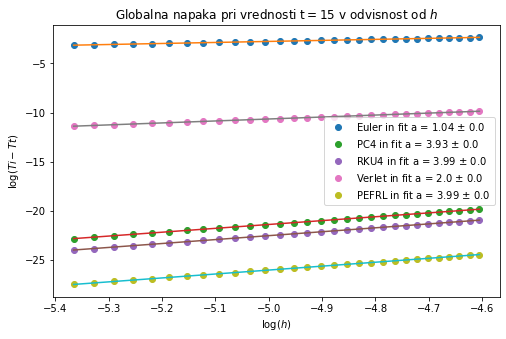

In [329]:
x_max = 15  # nima zares veze kero uzams, vazn da lah primerjas pac
hs = np.linspace(1e-3, 1e-2, 50)

euler = np.zeros_like(hs)
pc4 = np.zeros_like(hs)
rku4 = np.zeros_like(hs)
verlet = np.zeros_like(hs)
pefrl = np.zeros_like(hs)

for i in range(20, len(hs)):
    t = np.arange(0, end_t, hs[i])

    theta_exact = exact(t, theta0, w0)
    def diff_abs_exact(method):
        return np.abs(method - theta_exact)

    theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
    theta_euler = methods.euler(equations, [theta0, x0],  t)
    theta_pc4 = methods.pc4(equations, [theta0, x0],  t)

    theta_exact = exact(t, theta0, w0)

    theta_verlet = methods.verlet(f_2, theta0, x0, t)
    theta_pefrl = methods.pefrl(f_2, theta0, x0, t)


    euler[i] = np.max(diff_abs_exact(theta_euler[:, 0]))
    pc4[i] = np.max(diff_abs_exact(theta_pc4[:, 0]))
    rku4[i] = np.max(diff_abs_exact(theta_rku4[:, 0]))
    verlet[i] = np.max(diff_abs_exact(theta_verlet[0, :]))
    pefrl[i] = np.max(diff_abs_exact(theta_pefrl[0, :]))


def koef_and_draw(hs, data, name):
    x = np.log(hs)
    y = np.log(data)

    non_inf = np.argmax(y != -np.inf)

    x, y = x[non_inf:], y[non_inf:]

    popt, pcov = optimize.curve_fit(lin_fit, x, y)
    errs = np.sqrt(np.diag(pcov))

    a = popt[0], errs[0]

    plt.plot(
        x, y, 'o', label=f'{name} in fit a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    # , label=f'{name} fit; a = {round(a[0], 2)} $\pm$ {round(a[1], 2)}')
    plt.plot(x, lin_fit(x, *popt))


koef_and_draw(hs, euler, 'Euler')
koef_and_draw(hs, pc4, 'PC4')
koef_and_draw(hs, rku4, 'RKU4')
koef_and_draw(hs, verlet, 'Verlet')
koef_and_draw(hs, pefrl, 'PEFRL')

plt.legend()
plt.title("Globalna napaka pri vrednosti t$ = 15$ v odvisnost od $h$")
plt.xlabel(r"$\log(h)$")
plt.ylabel(r"$\log(Ti - Tt)$")
plt.savefig("grafi/globalne_napake.pdf", bbox_inches='tight')
plt.show()


Iz logaritmiranja napak lahko ugotovimo, da se teoretične napovedi, zares strinjajo z izračunom. Torej smo potrdili, da je metoda Verlet natančna do polinoma 2 stopnje, PEFRL pa do polinoma 4 stopnje.

## Ohranitev periode

Uporabil bom funkcijo `scipy.signal.argrelextrema` za izračun maksimumov.

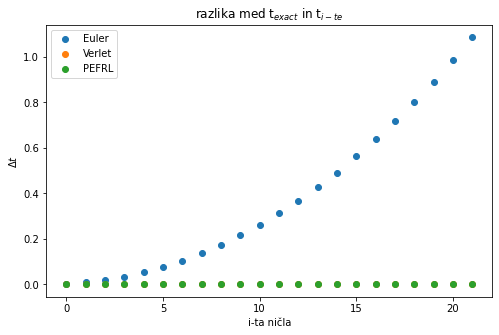

In [330]:
t = np.linspace(0, 150, 100000)

theta0 = 1.0
x0 = np.radians(0.0)

# find the solution to the nonlinear problem
# theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
theta_euler = methods.euler(equations, [theta0, x0],  t)
# theta_pc4 = methods.pc4(equations, [theta0, x0],  t)

theta_exact = exact(t, theta0, w0)

theta_verlet = methods.verlet(f_2, theta0, x0, t)
theta_pefrl = methods.pefrl(f_2, theta0, x0, t)

max_t_euler= t[signal.argrelextrema(theta_euler[:, 0], np.greater)]
max_t_verlet= t[signal.argrelextrema(theta_verlet[0, :], np.greater)]
max_t_exact = t[signal.argrelextrema(theta_exact, np.greater)]
max_t_pefrl = t[signal.argrelextrema(theta_pefrl[0, :], np.greater)]

delta_euler = np.abs(max_t_exact - max_t_euler)
delta_verlet = np.abs(max_t_exact - max_t_verlet)
delta_pefrl = np.abs(max_t_exact - max_t_pefrl)

plt.plot(delta_euler, 'o', label='Euler')
plt.plot(delta_verlet, 'o', label='Verlet')
plt.plot(delta_pefrl, 'o', label='PEFRL')

plt.xlabel('i-ta ničla')
plt.title('razlika med t$_{exact}$ in t$_{i-te}$')
plt.legend()
plt.ylabel('$\Delta t$')

plt.savefig("grafi/razlike_t.pdf", bbox_inches='tight')
plt.show()

Iz grafa lahko odčitamo, da se pri simplektičnih metodah zelo malo razlikjejo nihajni časi od dejanske eksaktne vrednosti - verjetno se tudi pokvarijo, vendar nisem uspel izračunati dovolj veliko točk, da bi se razlika opazila. 

## Ohranitev Energije

In [331]:
def E(theta, theta_dot):
    return 1 - np.cos(theta) + theta_dot**2 / (2 * w0**2)

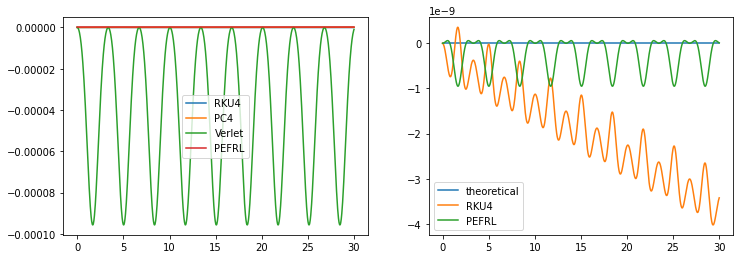

In [332]:
t = np.linspace(0, 30, 1000)

theta0 = 1.0
x0 = np.radians(0.0)

# find the solution to the nonlinear problem
theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
theta_euler = methods.euler(equations, [theta0, x0],  t)
theta_pc4 = methods.pc4(equations, [theta0, x0],  t)

theta_verlet = methods.verlet(f_2, theta0, x0, t)
theta_pefrl = methods.pefrl(f_2, theta0, x0, t)


E_rku4 = E(theta_rku4[:, 0], theta_rku4[:, 1])
E_euler = E(theta_euler[:, 0], theta_euler[:, 1])
E_pc4 = E(theta_pc4[:, 0], theta_pc4[:, 1])
E_verlet = E(theta_verlet[0, :], theta_verlet[1, :])
E_pefrl = E(theta_pefrl[0, :], theta_pefrl[1, :])


plt.figure(figsize=(12, 4))
plt.subplot(121)

plt.subplot(1, 2, 1)
plt.plot(t, E_rku4-E_rku4[0], label='RKU4')
plt.plot(t, E_pc4-E_pc4[0], label='PC4')
plt.plot(t, E_verlet-E_verlet[0], label='Verlet')
plt.plot(t, E_pefrl-E_pefrl[0], label='PEFRL')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([0,t[-1]], [0]*2, label='theoretical')
plt.plot(t, E_rku4-E_rku4[0], label='RKU4')
plt.plot(t, E_pefrl-E_pefrl[0], label='PEFRL')

plt.legend()

plt.savefig("grafi/energije.pdf", bbox_inches='tight')
plt.show()

Vidimo, da so metoda iz vidika ohranitve energije zelo natančne, vendar ob bolj natančnem pogledu se opazi, da energija pri RKU4 linearno (in periodično) pada. Prednost simplektičnih metod je zelo dobro vidna na grafu, ker pri velikih časih konvergira in ne divergira.

## Fazni portreti

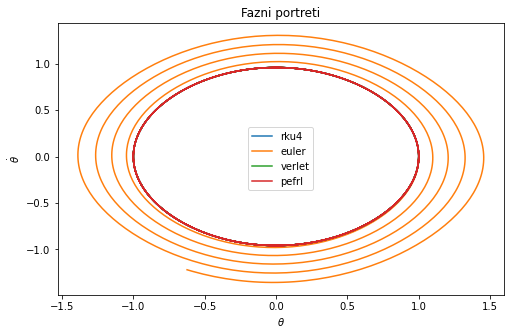

In [333]:
plt.plot(theta_rku4[:, 0], theta_rku4[:, 1], label='rku4')
plt.plot(theta_euler[:, 0], theta_euler[:, 1], label='euler')
plt.plot(theta_verlet[0, :], theta_verlet[1, :], label='verlet')
plt.plot(theta_pefrl[0, :], theta_pefrl[1, :], label='pefrl')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot\theta$')
plt.title('Fazni portreti')
plt.legend()

plt.savefig("grafi/fazni_basic.pdf", bbox_inches='tight')

plt.show()

Fazni potreti vseh metod na izgled sovpadajo, ker so tako blizu. Eulerjeva metoda pride kot nakakšna spirala, ki se s časom povečuje, ker raste energija. Pri navadnem matematičnem nihalu niso portreti nič kaj preveč zanimivi, zato je za lepš izlged smiselno narisati tudi parametrizirano verzijo, kjer se začetni kot spreminja.

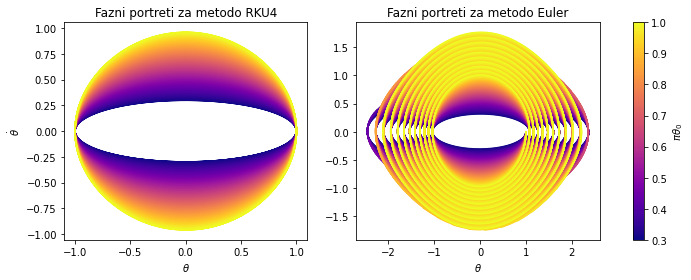

In [334]:
N = 100
thetas = np.linspace(0.3, 1, N)

cmap = plt.get_cmap('plasma', len(thetas))

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
ax0, ax1 = axes

time = np.arange(0, 15, 0.025)
for i in range(len(thetas)):
    theta_rku4 = methods.rku4(equations, [thetas[i], 0],  time)
    ax0.plot(theta_rku4[:, 0]/thetas[i], theta_rku4[:, 1],c=cmap(i))


ax0.set_title(r'Fazni portreti za metodo RKU4')
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\dot\theta$')

time = np.arange(0, 75, 0.025)
for i in range(len(thetas)):
    theta_rku4 = methods.euler(equations, [thetas[i], 0],  time)
    ax1.plot(theta_rku4[:, 0]/thetas[i], theta_rku4[:, 1], c=cmap(i))

norm = mpl.colors.Normalize(vmin=thetas[0], vmax=thetas[-1])

# creating ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax1.set_title(r'Fazni portreti za metodo Euler')
ax1.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\dot\theta$')


fig.colorbar(sm, ax=axes,label=r'$\pi \theta_0$')

plt.savefig("grafi/fazni_clusterfuck.pdf", bbox_inches='tight')


plt.show()

Kar lahko opazimo iz tega grafa je, da se z manjšim kotom fazni portret oža (največja hitrost je čedalje manjša). Poleg tega lahko narišemo tudi Eulerjevo metodo, ki ima zelo unikaten in zanimiv izgled, ki bi ga verjetno lahko uporabili v kakšni Egipčanski piramidi.

## Dodatna #1


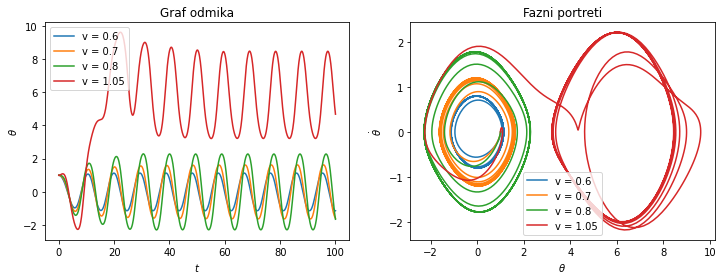

In [335]:
beta = 0.5
omega_0 = 2/3
vs = [0.6,0.7,0.8,1.05,]

theta0 = 1.
x0 = 0
t = np.linspace(0, 100, 1000)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
ax0, ax1 = axes

for v in vs:
	def equations(y0, t):
		# x == theta_dot; goodnotes :)
		theta, theta_dot = y0
		f = np.array([theta_dot, - beta * theta_dot - np.sin(theta) + v*np.cos(omega_0*t)], dtype=np.float64)
		return f


	theta_rku4 = methods.rku4(equations, [theta0, x0],  t)
	ax1.plot(theta_rku4[:, 0], theta_rku4[:, 1], label=f'v = {v}')
	ax0.plot(t, theta_rku4[:, 0], label=f'v = {v}')

ax0.legend()
ax0.set_xlabel(r'$t$')
ax0.set_ylabel(r'$\theta$')
ax0.set_title('Graf odmika')


ax1.legend()
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\dot\theta$')
ax1.set_title('Fazni portreti')

plt.savefig("grafi/dodatna_fazni.pdf", bbox_inches='tight')

plt.show()

Zdaj, ko imamo za najlažji primer napisane funkcije, ni težko narediti precej bolj zakomplicirane funkcije.

## Van Der Pool

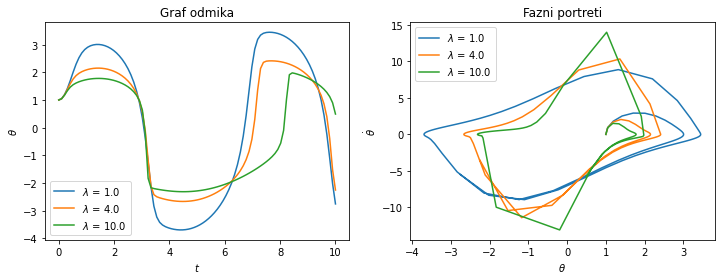

In [336]:
from scipy.integrate import odeint

lambdas = [1., 4., 10.]
omega_0 = 1.
v = 10.

theta0 = 1.
x0 = 0.
t = np.linspace(0, 10, 97)
0
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
ax0, ax1 = axes

for lam in lambdas:
	def equations(y0, t):
		# x == theta_dot; goodnotes :)
		theta, theta_dot = y0
		f = np.array([theta_dot, + lam * (1-theta**2)*theta_dot -
		             theta + v*np.cos(omega_0*t)], dtype=np.float64)
		return f

	theta_rku4 = odeint(equations, [theta0, x0],  t)
	ax1.plot(theta_rku4[:, 0], theta_rku4[:, 1], label=f'$\lambda$ = {lam}')
	ax0.plot(t, theta_rku4[:, 0], label=f'$\lambda$ = {lam}')

ax0.legend()
ax0.set_xlabel(r'$t$')
ax0.set_ylabel(r'$\theta$')
ax0.set_title('Graf odmika')


ax1.legend()
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\dot\theta$')
ax1.set_title('Fazni portreti')

plt.savefig("grafi/van_der_pool_fazni.pdf", bbox_inches='tight')

plt.show()


Za izračun Van Der Poola sem moral uporabiti integrerano funkcijo Scipy-ja Odeint.